In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import pylab
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras import optimizers
from keras.layers import Activation
from keras.layers import Dropout, Dense, LSTM
from keras.optimizers import Adam

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Using TensorFlow backend.


In [0]:
#Download Data Frame
data = pd.read_csv('CL_megafon_Cup IT_2020_final_data.csv', sep = ';', parse_dates = ['time_start', 'time_end'])

In [0]:
#Download test Data Frame
test = pd.read_csv('test.csv', sep = ';', parse_dates = ['time_start'])

In [0]:
predictions = test.copy()
predictions['month_start'] = predictions.time_start.apply(lambda x: x.month)
predictions['day_of_week_start'] = predictions.time_start.apply(lambda x: x.dayofweek+1)
predictions['hour_start'] = predictions.time_start.apply(lambda x: x.hour)
predictions.index = predictions['time_start']
predictions = predictions.drop(['time_start'], axis = 1)

In [0]:
#Preparing data to work with time series
data['month_start'] = data.time_start.apply(lambda x: x.month)
data['day_of_week_start'] = data.time_start.apply(lambda x: x.dayofweek+1)
data['hour_start'] = data.time_start.apply(lambda x: x.hour)
data['gap'] = data.time_end-data.time_start
data['gap'] = data.gap.apply(lambda x: x.seconds)
data = data.drop(['time_end'], axis = 1)
data = data.sort_values('time_start')

In [0]:
test['month_start'] = test.time_start.apply(lambda x: x.month)
test['day_of_week_start'] = test.time_start.apply(lambda x: x.dayofweek+1)
test['hour_start'] = test.time_start.apply(lambda x: x.hour)

In [0]:
#Data Frame with columns, that have useful infromation
data.head()

,time_start,place_latitude,place_longitude,month_start,day_of_week_start,hour_start,gap
73313,2018-01-01 04:35:56,28.227964,113.565739,1,1,4,28343
17836,2018-01-01 09:30:40,28.871813,114.592832,1,1,9,4036
5389,2018-01-01 09:57:24,28.844192,114.560353,1,1,9,1145
53801,2018-01-01 10:06:01,28.768786,114.582630,1,1,10,9868
56346,2018-01-01 11:07:07,28.650852,114.595380,1,1,11,11494


In [0]:
#New Data Frame for saving old
newdata = data.copy()

In [0]:
#Min and max values of all important features for normalize values
min_place_latitude = newdata.place_latitude.min()
max_place_latitude = newdata.place_latitude.max()
min_place_longitude = newdata.place_longitude.min()
max_place_longitude = newdata.place_longitude.max()
min_m = newdata.month_start.min()
max_m = newdata.month_start.max()
min_d = newdata.day_of_week_start.min()
max_d = newdata.day_of_week_start.max()
min_h = newdata.hour_start.min()
max_h = newdata.hour_start.max()
min_gap = newdata.gap.min()
max_gap = newdata.gap.max()

In [0]:
#Functions of normalize values
def scaled(x):
    r = x
    r[1] = (r[1]-min_place_latitude)/(max_place_latitude-min_place_latitude)
    r[2] = (r[2]-min_place_longitude)/(max_place_longitude-min_place_longitude)
    r[3] = (r[3]-min_m)/(max_m-min_m)
    r[4] = (r[4]-min_d)/(max_d-min_d)
    r[5] = (r[5]-min_h)/(max_h-min_h)
    r[6] = (r[6]-min_gap)/(max_gap-min_gap)
    return r
def scaled_test(x):
    r = x
    r[1] = (r[1]-min_place_latitude)/(max_place_latitude-min_place_latitude)
    r[2] = (r[2]-min_place_longitude)/(max_place_longitude-min_place_longitude)
    r[3] = (r[3]-min_m)/(max_m-min_m)
    r[4] = (r[4]-min_d)/(max_d-min_d)
    r[5] = (r[5]-min_h)/(max_h-min_h)
    return r

In [0]:
#Making train data with normalize values for predicting
train_data = newdata.apply(scaled, axis = 1)

In [0]:
test_data = test.apply(scaled_test, axis = 1)

In [0]:
#Making data for clastering location
claster_data = train_data.groupby(['place_latitude', 'place_longitude']).agg({'gap': 'mean'})\
.reset_index()[['place_latitude', 'place_longitude']]
clf = KMeans(init = 'k-means++', n_clusters=13, random_state = 241)
clf.fit(claster_data)
claster_data['claster'] = pd.Series(clf.labels_)

In [0]:
#Making new column with labels of Area
train_data = train_data.merge(claster_data, on = ['place_latitude', 'place_longitude'])
train_data.index = train_data['time_start']
train_data = train_data.drop(['time_start'], axis = 1)

In [0]:
test_data['claster'] = pd.Series(clf.predict(test_data[['place_latitude', 'place_longitude']]))

In [0]:
test_data.index = test_data['time_start']
test_data = test_data.drop(['time_start'], axis = 1)

In [0]:
#Our prepeared data
train_data

,place_latitude,place_longitude,month_start,day_of_week_start,hour_start,gap,claster
time_start,,,,,,,
2018-01-01 04:35:56,0.246287,0.512318,0.000000,0.000000,0.173913,0.328066,2
2018-01-01 19:30:47,0.246287,0.512318,0.000000,0.000000,0.826087,0.021866,2
2018-06-09 07:24:48,0.246287,0.512318,0.454545,0.833333,0.304348,0.193916,2
2019-05-07 12:59:15,0.246287,0.512318,0.363636,0.166667,0.521739,0.032528,2
2019-05-08 14:15:40,0.246287,0.512318,0.363636,0.333333,0.608696,0.031115,2
...,...,...,...,...,...,...,...
2020-01-28 18:29:39,0.383989,0.575655,0.000000,0.166667,0.782609,0.140112,6
2020-01-29 13:24:14,0.303190,0.769237,0.000000,0.333333,0.565217,0.054232,1
2020-01-30 01:16:02,0.362559,0.665687,0.000000,0.500000,0.043478,0.107827,6


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

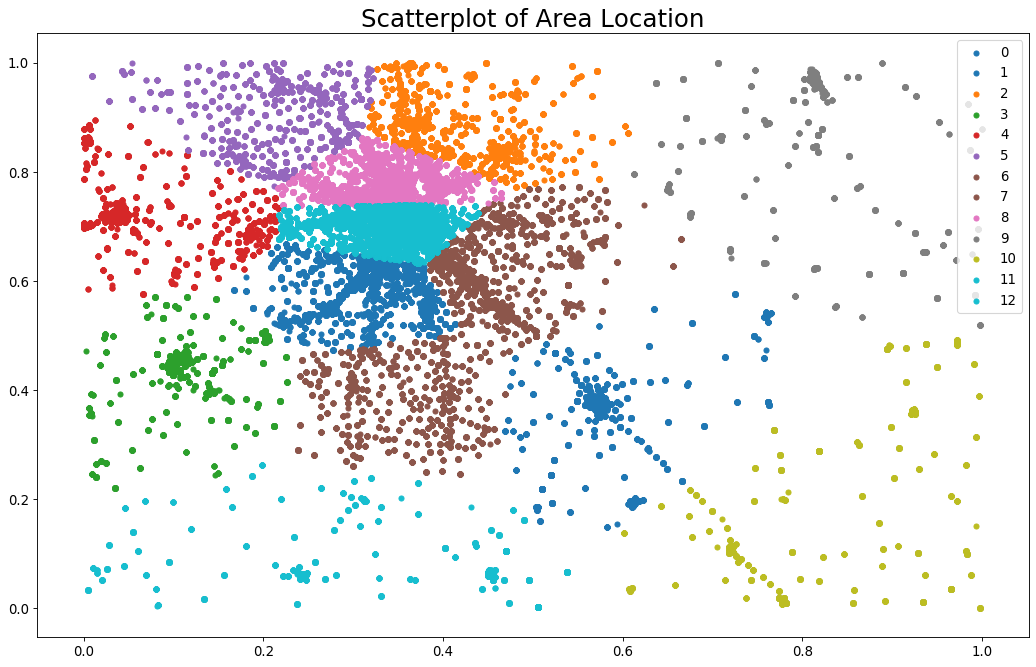

In [0]:
categories = np.unique(train_data['claster'])
colors = [plt.cm.tab10(i/float(len(categories)-1)) for i in range(len(categories))]
plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')
for i, category in enumerate(categories):
    plt.scatter('place_latitude', 'place_longitude', 
                data=train_data.loc[train_data.claster==category].iloc[:,:2], 
                s=20, c=colors[i], label=str(category))

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Scatterplot of Area Location", fontsize=22)
plt.legend(fontsize=12)    
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

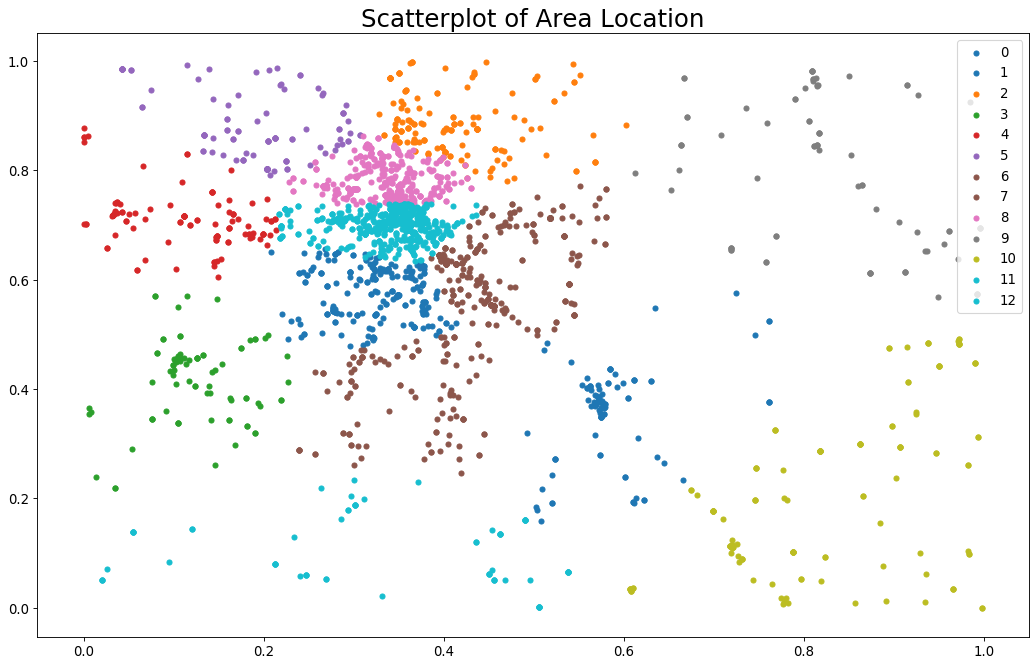

In [0]:
categories = np.unique(test_data['claster'])
colors = [plt.cm.tab10(i/float(len(categories)-1)) for i in range(len(categories))]
plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')
for i, category in enumerate(categories):
    plt.scatter('place_latitude', 'place_longitude', 
                data=test_data.loc[test_data.claster==category].iloc[:,:2], 
                s=20, c=colors[i], label=str(category))

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Scatterplot of Area Location", fontsize=22)
plt.legend(fontsize=12)    
plt.show()

In [20]:
!pip install tensorflow==1.14

     |████████████████████████████████| 109.2MB 93kB/s 
     |████████████████████████████████| 491kB 55.1MB/s 
     |████████████████████████████████| 3.2MB 15.4MB/s 
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorboard 2.1.1
    Uninstalling tensorboard-2.1.1:
      Successfully uninstalled tensorboard-2.1.1
  Found existing installation: tensorflow 2.2.0rc1
    Uninstalling tensorflow-2.2.0rc1:
      Successfully uninstalled tensorflow-2.2.0rc1


In [0]:
model = []

Train on 1788 samples, validate on 447 samples
Epoch 1/20
1788/1788 [==============================] - 6s 3ms/step - loss: 61.7500 - val_loss: 56.8009
Epoch 2/20
1788/1788 [==============================] - 2s 1ms/step - loss: 58.7903 - val_loss: 56.7492
Epoch 3/20
1788/1788 [==============================] - 2s 1ms/step - loss: 58.3743 - val_loss: 57.0311
Epoch 4/20
1788/1788 [==============================] - 2s 1ms/step - loss: 58.8346 - val_loss: 56.8929
Epoch 5/20
1788/1788 [==============================] - 2s 1ms/step - loss: 58.3728 - val_loss: 56.7943
Epoch 6/20
1788/1788 [==============================] - 2s 1ms/step - loss: 58.6201 - val_loss: 56.7092
Epoch 7/20
1788/1788 [==============================] - 2s 1ms/step - loss: 58.3748 - val_loss: 56.8359
Epoch 8/20
1788/1788 [==============================] - 2s 1ms/step - loss: 58.1118 - val_loss: 56.6108
Epoch 9/20
1788/1788 [==============================] - 2s 1ms/step - loss: 58.2645 - val_loss: 56.5657
Epoch 10/20
1788/

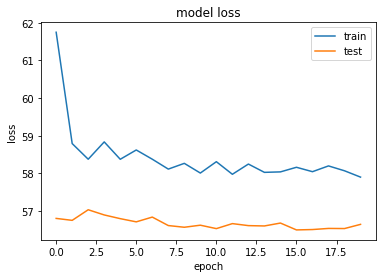

Train on 13807 samples, validate on 3452 samples
Epoch 1/20
13807/13807 [==============================] - 20s 1ms/step - loss: 77.2882 - val_loss: 73.1010
Epoch 2/20
13807/13807 [==============================] - 15s 1ms/step - loss: 77.3420 - val_loss: 73.4757
Epoch 3/20
13807/13807 [==============================] - 15s 1ms/step - loss: 77.6950 - val_loss: 72.6244
Epoch 4/20
13807/13807 [==============================] - 15s 1ms/step - loss: 76.9247 - val_loss: 72.2758
Epoch 5/20
13807/13807 [==============================] - 15s 1ms/step - loss: 76.7896 - val_loss: 72.7481
Epoch 6/20
13807/13807 [==============================] - 15s 1ms/step - loss: 77.1594 - val_loss: 72.7101
Epoch 7/20
13807/13807 [==============================] - 15s 1ms/step - loss: 77.2122 - val_loss: 72.2074
Epoch 8/20
13807/13807 [==============================] - 15s 1ms/step - loss: 76.9021 - val_loss: 72.5314
Epoch 9/20
13807/13807 [==============================] - 15s 1ms/step - loss: 76.6535 - val_lo

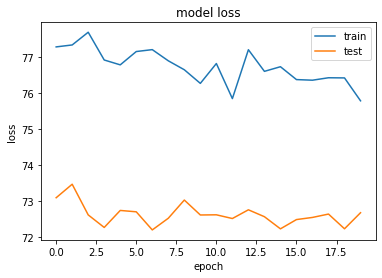

Train on 2764 samples, validate on 692 samples
Epoch 1/20
2764/2764 [==============================] - 7s 3ms/step - loss: 71.6032 - val_loss: 67.6675
Epoch 2/20
2764/2764 [==============================] - 3s 1ms/step - loss: 67.2278 - val_loss: 67.6594
Epoch 3/20
2764/2764 [==============================] - 3s 1ms/step - loss: 67.2259 - val_loss: 67.6083
Epoch 4/20
2764/2764 [==============================] - 3s 1ms/step - loss: 68.0514 - val_loss: 67.6188
Epoch 5/20
2764/2764 [==============================] - 3s 1ms/step - loss: 66.7308 - val_loss: 67.6238
Epoch 6/20
2764/2764 [==============================] - 3s 1ms/step - loss: 68.7182 - val_loss: 67.5808
Epoch 7/20
2764/2764 [==============================] - 3s 1ms/step - loss: 67.0825 - val_loss: 67.5689
Epoch 8/20
2764/2764 [==============================] - 3s 1ms/step - loss: 68.3193 - val_loss: 67.5726
Epoch 9/20
2764/2764 [==============================] - 3s 1ms/step - loss: 65.6128 - val_loss: 67.6548
Epoch 10/20
2764/

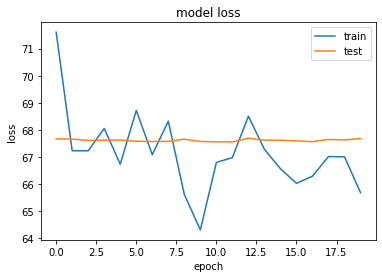

Train on 2952 samples, validate on 738 samples
Epoch 1/20
2952/2952 [==============================] - 8s 3ms/step - loss: 75.4817 - val_loss: 59.5149
Epoch 2/20
2952/2952 [==============================] - 3s 1ms/step - loss: 72.7613 - val_loss: 59.4461
Epoch 3/20
2952/2952 [==============================] - 3s 1ms/step - loss: 71.7277 - val_loss: 59.2686
Epoch 4/20
2952/2952 [==============================] - 3s 1ms/step - loss: 72.3970 - val_loss: 59.5165
Epoch 5/20
2952/2952 [==============================] - 3s 1ms/step - loss: 72.1885 - val_loss: 59.6203
Epoch 6/20
2952/2952 [==============================] - 3s 1ms/step - loss: 72.6303 - val_loss: 59.5409
Epoch 7/20
2952/2952 [==============================] - 3s 1ms/step - loss: 72.5264 - val_loss: 59.5099
Epoch 8/20
2952/2952 [==============================] - 3s 1ms/step - loss: 71.4913 - val_loss: 59.2498
Epoch 9/20
2952/2952 [==============================] - 3s 1ms/step - loss: 72.1621 - val_loss: 59.2410
Epoch 10/20
2952/

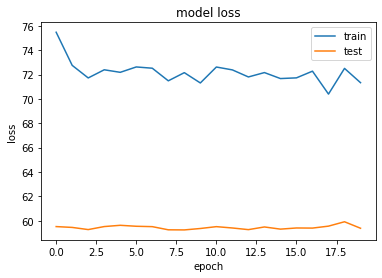

Train on 4539 samples, validate on 1135 samples
Epoch 1/20
4539/4539 [==============================] - 10s 2ms/step - loss: 64.9145 - val_loss: 58.7004
Epoch 2/20
4539/4539 [==============================] - 5s 1ms/step - loss: 63.4784 - val_loss: 58.6235
Epoch 3/20
4539/4539 [==============================] - 5s 1ms/step - loss: 63.1880 - val_loss: 58.6479
Epoch 4/20
4539/4539 [==============================] - 5s 1ms/step - loss: 63.2113 - val_loss: 58.6261
Epoch 5/20
4539/4539 [==============================] - 5s 1ms/step - loss: 63.2374 - val_loss: 58.6828
Epoch 6/20
4539/4539 [==============================] - 5s 1ms/step - loss: 63.2066 - val_loss: 58.6183
Epoch 7/20
4539/4539 [==============================] - 5s 1ms/step - loss: 63.0818 - val_loss: 58.7761
Epoch 8/20
4539/4539 [==============================] - 4s 985us/step - loss: 63.1851 - val_loss: 58.6050
Epoch 9/20
4539/4539 [==============================] - 5s 1ms/step - loss: 63.0886 - val_loss: 58.6139
Epoch 10/20
4

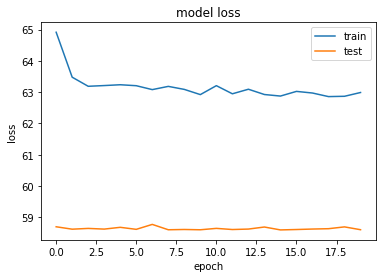

Train on 3447 samples, validate on 862 samples
Epoch 1/20
3447/3447 [==============================] - 10s 3ms/step - loss: 58.1417 - val_loss: 57.1527
Epoch 2/20
3447/3447 [==============================] - 4s 1ms/step - loss: 56.0053 - val_loss: 57.0928
Epoch 3/20
3447/3447 [==============================] - 3s 1ms/step - loss: 56.0703 - val_loss: 57.1222
Epoch 4/20
3447/3447 [==============================] - 3s 994us/step - loss: 56.1646 - val_loss: 57.1203
Epoch 5/20
3447/3447 [==============================] - 3s 1ms/step - loss: 55.9480 - val_loss: 57.1828
Epoch 6/20
3447/3447 [==============================] - 3s 1ms/step - loss: 55.8277 - val_loss: 57.1010
Epoch 7/20
3447/3447 [==============================] - 3s 987us/step - loss: 55.8367 - val_loss: 57.1152
Epoch 8/20
3447/3447 [==============================] - 3s 990us/step - loss: 55.6627 - val_loss: 57.0540
Epoch 9/20
3447/3447 [==============================] - 4s 1ms/step - loss: 55.8125 - val_loss: 57.0965
Epoch 10/2

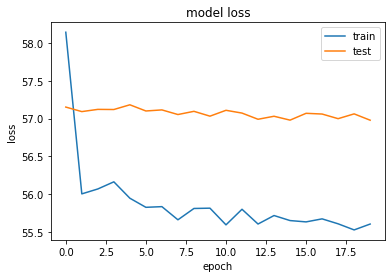

Train on 6977 samples, validate on 1745 samples
Epoch 1/20
6977/6977 [==============================] - 13s 2ms/step - loss: 108.6093 - val_loss: 61.0296
Epoch 2/20
6977/6977 [==============================] - 7s 1ms/step - loss: 101.6512 - val_loss: 61.2630
Epoch 3/20
6977/6977 [==============================] - 7s 1ms/step - loss: 99.9566 - val_loss: 61.4387
Epoch 4/20
6977/6977 [==============================] - 7s 989us/step - loss: 101.2044 - val_loss: 62.1203
Epoch 5/20
6977/6977 [==============================] - 7s 999us/step - loss: 114.5811 - val_loss: 64.6848
Epoch 6/20
6977/6977 [==============================] - 7s 1ms/step - loss: 100.7208 - val_loss: 65.5953
Epoch 7/20
6977/6977 [==============================] - 7s 996us/step - loss: 116.5920 - val_loss: 65.0907
Epoch 8/20
6977/6977 [==============================] - 7s 980us/step - loss: 109.6888 - val_loss: 62.6315
Epoch 9/20
6977/6977 [==============================] - 7s 993us/step - loss: 125.4555 - val_loss: 65.22

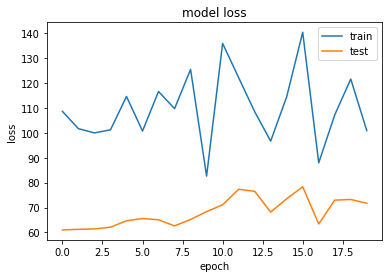

Train on 5744 samples, validate on 1437 samples
Epoch 1/20
5744/5744 [==============================] - 13s 2ms/step - loss: 84.3688 - val_loss: 101.4925
Epoch 2/20
5744/5744 [==============================] - 6s 977us/step - loss: 84.1789 - val_loss: 103.0557
Epoch 3/20
5744/5744 [==============================] - 6s 977us/step - loss: 86.1419 - val_loss: 101.2640
Epoch 4/20
5744/5744 [==============================] - 6s 968us/step - loss: 87.0209 - val_loss: 102.3025
Epoch 5/20
5744/5744 [==============================] - 6s 973us/step - loss: 79.9563 - val_loss: 103.2262
Epoch 6/20
5744/5744 [==============================] - 6s 970us/step - loss: 84.6439 - val_loss: 104.0276
Epoch 7/20
5744/5744 [==============================] - 6s 967us/step - loss: 84.0383 - val_loss: 105.6293
Epoch 8/20
5744/5744 [==============================] - 6s 985us/step - loss: 81.2217 - val_loss: 105.9263
Epoch 9/20
5744/5744 [==============================] - 6s 991us/step - loss: 83.9940 - val_loss:

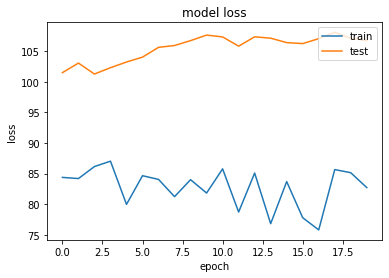

Train on 2884 samples, validate on 721 samples
Epoch 1/20
2884/2884 [==============================] - 11s 4ms/step - loss: 70.9479 - val_loss: 62.2625
Epoch 2/20
2884/2884 [==============================] - 3s 1ms/step - loss: 69.1988 - val_loss: 62.5952
Epoch 3/20
2884/2884 [==============================] - 3s 1ms/step - loss: 69.2596 - val_loss: 62.3249
Epoch 4/20
2884/2884 [==============================] - 3s 1ms/step - loss: 70.0024 - val_loss: 62.7632
Epoch 5/20
2884/2884 [==============================] - 3s 1ms/step - loss: 69.3209 - val_loss: 62.5030
Epoch 6/20
2884/2884 [==============================] - 3s 1ms/step - loss: 70.0063 - val_loss: 62.5916
Epoch 7/20
2884/2884 [==============================] - 3s 1ms/step - loss: 69.6344 - val_loss: 62.7317
Epoch 8/20
2884/2884 [==============================] - 3s 1ms/step - loss: 69.6879 - val_loss: 62.3774
Epoch 9/20
2884/2884 [==============================] - 3s 1ms/step - loss: 69.3148 - val_loss: 62.5282
Epoch 10/20
2884

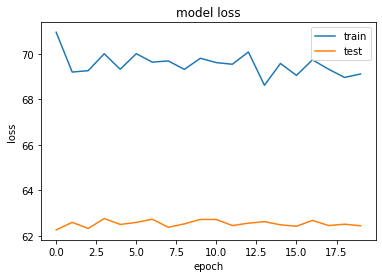

Train on 4068 samples, validate on 1018 samples
Epoch 1/20
4068/4068 [==============================] - 12s 3ms/step - loss: 91.7072 - val_loss: 179.6820
Epoch 2/20
4068/4068 [==============================] - 4s 1ms/step - loss: 80.0166 - val_loss: 183.5935
Epoch 3/20
4068/4068 [==============================] - 4s 1ms/step - loss: 91.4362 - val_loss: 162.7168
Epoch 4/20
4068/4068 [==============================] - 4s 1ms/step - loss: 84.8673 - val_loss: 153.0333
Epoch 5/20
4068/4068 [==============================] - 4s 1ms/step - loss: 86.2324 - val_loss: 143.5305
Epoch 6/20
4068/4068 [==============================] - 4s 1ms/step - loss: 82.3483 - val_loss: 133.3863
Epoch 7/20
4068/4068 [==============================] - 4s 1ms/step - loss: 83.4903 - val_loss: 141.6444
Epoch 8/20
4068/4068 [==============================] - 4s 1ms/step - loss: 93.5943 - val_loss: 121.1557
Epoch 9/20
4068/4068 [==============================] - 4s 1ms/step - loss: 80.0009 - val_loss: 136.1574
Epoch 

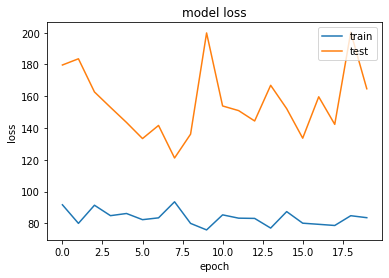

Train on 9460 samples, validate on 2366 samples
Epoch 1/20
9460/9460 [==============================] - 18s 2ms/step - loss: 4657.7709 - val_loss: 78.9483
Epoch 2/20
9460/9460 [==============================] - 10s 1ms/step - loss: 3235.6978 - val_loss: 81.9487
Epoch 3/20
9460/9460 [==============================] - 10s 1ms/step - loss: 1630.3646 - val_loss: 88.3753
Epoch 4/20
9460/9460 [==============================] - 10s 1ms/step - loss: 682.8452 - val_loss: 98.0681
Epoch 5/20
9460/9460 [==============================] - 10s 1ms/step - loss: 136.1351 - val_loss: 80.0004
Epoch 6/20
9460/9460 [==============================] - 10s 1ms/step - loss: 2524.4508 - val_loss: 95.9142
Epoch 7/20
9460/9460 [==============================] - 10s 1ms/step - loss: 826.1558 - val_loss: 81.4286
Epoch 8/20
9460/9460 [==============================] - 10s 1ms/step - loss: 1149.9278 - val_loss: 81.8157
Epoch 9/20
9460/9460 [==============================] - 10s 1ms/step - loss: 4686.7361 - val_loss: 

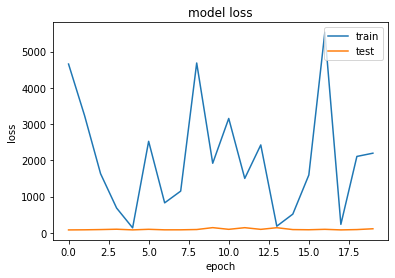

Train on 1840 samples, validate on 461 samples
Epoch 1/20
1840/1840 [==============================] - 11s 6ms/step - loss: 60.8201 - val_loss: 54.3098
Epoch 2/20
1840/1840 [==============================] - 2s 1ms/step - loss: 57.4498 - val_loss: 54.5836
Epoch 3/20
1840/1840 [==============================] - 2s 1ms/step - loss: 57.0453 - val_loss: 54.4697
Epoch 4/20
1840/1840 [==============================] - 2s 1ms/step - loss: 57.2065 - val_loss: 54.3098
Epoch 5/20
1840/1840 [==============================] - 2s 1ms/step - loss: 57.2234 - val_loss: 54.3952
Epoch 6/20
1840/1840 [==============================] - 2s 997us/step - loss: 56.7045 - val_loss: 54.4030
Epoch 7/20
1840/1840 [==============================] - 2s 1000us/step - loss: 56.8939 - val_loss: 54.5299
Epoch 8/20
1840/1840 [==============================] - 2s 1ms/step - loss: 57.0269 - val_loss: 54.3982
Epoch 9/20
1840/1840 [==============================] - 2s 1ms/step - loss: 57.1844 - val_loss: 54.3124
Epoch 10/20

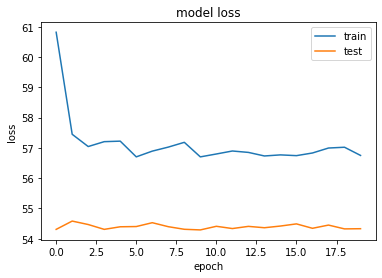

Train on 2303 samples, validate on 576 samples
Epoch 1/20
2303/2303 [==============================] - 12s 5ms/step - loss: 60.1949 - val_loss: 56.2125
Epoch 2/20
2303/2303 [==============================] - 2s 1ms/step - loss: 57.5932 - val_loss: 56.4214
Epoch 3/20
2303/2303 [==============================] - 2s 994us/step - loss: 57.6757 - val_loss: 56.6458
Epoch 4/20
2303/2303 [==============================] - 2s 1ms/step - loss: 57.5894 - val_loss: 56.2300
Epoch 5/20
2303/2303 [==============================] - 2s 1ms/step - loss: 57.3792 - val_loss: 56.6458
Epoch 6/20
2303/2303 [==============================] - 2s 1ms/step - loss: 57.3209 - val_loss: 56.5634
Epoch 7/20
2303/2303 [==============================] - 2s 998us/step - loss: 57.2324 - val_loss: 56.4509
Epoch 8/20
2303/2303 [==============================] - 2s 988us/step - loss: 57.4434 - val_loss: 56.5155
Epoch 9/20
2303/2303 [==============================] - 2s 985us/step - loss: 57.1938 - val_loss: 56.4880
Epoch 10

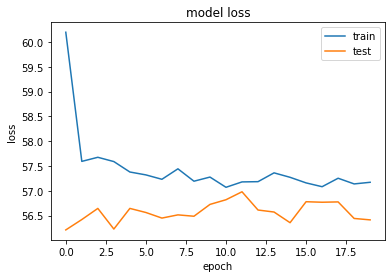

In [20]:
#Basic MODEL to predict time
for i in range(13):
    model.append('')
    X = train_data.query('claster==@i').drop(['gap', 'claster'], axis=1)
    y = train_data.query('claster==@i').gap
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    X_train, y_train = X_train.values, y_train.values
    X_test, y_test = X_test.values, y_test.values
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    model[i] = Sequential()
    model[i].add(Activation('linear'))
    model[i].add(LSTM(128, return_sequences=True,
               input_shape=(X_train.shape[1], X_train.shape[2])))
    model[i].add(LSTM(64, return_sequences=True))
    model[i].add(LSTM(64, return_sequences=True))
    model[i].add(LSTM(32))
    model[i].add(Activation('softsign'))
    model[i].add(Dropout(0.5))
    model[i].add(Dense(1, activation='tanh'))
    adam = optimizers.Adam(lr=0.0003, amsgrad=False)
    model[i].compile(loss='mean_absolute_percentage_error', optimizer=adam)
    history = model[i].fit(X_train, y_train, epochs=20, batch_size=8, 
                              validation_data=(X_test, y_test), verbose=1, shuffle=False)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

In [0]:
#MAPE metric function
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
#Checking of score
for i in range(13):
    X = train_data.query('claster==@i').drop(['gap', 'claster'], axis=1)
    y = train_data.query('claster==@i').gap
    X_train, X_test1, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    X_train, y_train = X_train.values, y_train.values
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    y_pred = np.array([k[0] for k in model[i].predict(X_train)])
    y_pred = y_pred*(max_gap-min_gap) + min_gap
    y_train = y_train*(max_gap-min_gap) + min_gap
    print(y_pred[:10]-y_train[:10])
    print(i, mean_absolute_percentage_error(y_train, y_pred))

[ -4031.81760634   1493.99550517 -13898.86510144  -3164.76193984
 -59746.59558626 -26765.5974969     614.3391971   -2321.52761748
    996.61494665   1296.6754439 ]
0 57.86558356464977
[ -3497.82545553  -1901.22631151 -40972.6237461  -13662.67128616
   -384.48756384 -26010.77405994  -4441.91797717 -12708.22101219
 -24993.81938706 -17336.22946332]
1 75.4579451024521
[   466.36399792 -10369.10631558  -3322.68167531 -12652.96362326
  -3326.38150798 -11634.65610801 -36998.46476187 -23260.08660035
  -7230.49213612  -3939.20341197]
2 64.48661662615262
[-19889.68025122 -23072.4568744    -232.05851549   -164.22709674
  -4698.24483611    976.33447617  -3986.10732714 -19898.47094533
   -616.76197657   -360.47045877]
3 69.94696532804652
[   376.43041843   -707.31602423   -221.19367623   1985.33462693
    415.54177785    986.18838923 -13639.39051551 -27754.4755419
  -4275.27845275  -5664.34803636]
4 62.65811707192385
[   273.88273638   -934.63864401    662.03992403  -9847.49330786
  -4152.54059516 

In [0]:
Shapes = []
X_data = []
for i in range(13):
    X_data.append('')
    X_data[i] = test_data.query('claster==@i')
    Shapes.append(X_data[i].shape[0])

In [0]:
X_test = []
X_test.append(np.zeros((1788, 1, 5)))
X_test.append(np.zeros((13807, 1, 5)))
X_test.append(np.zeros((2764, 1, 5)))
X_test.append(np.zeros((2952, 1, 5)))
X_test.append(np.zeros((4539, 1, 5)))
X_test.append(np.zeros((3447, 1, 5)))
X_test.append(np.zeros((6977, 1, 5)))
X_test.append(np.zeros((5744, 1, 5)))
X_test.append(np.zeros((2884, 1, 5)))
X_test.append(np.zeros((4068, 1, 5)))
X_test.append(np.zeros((9460, 1, 5)))
X_test.append(np.zeros((1840, 1, 5)))
X_test.append(np.zeros((2303, 1, 5)))

In [0]:
X_pred = []
for i in range(13):
    X_pred.append(test_data.query('claster==@i'))
    X_pred[i] = X_pred[i].drop(['claster'], axis = 1).values
    X_pred[i] = X_pred[i].reshape((X_pred[i].shape[0], 1, X_pred[i].shape[1]))

In [0]:
for i in range(13):
    for j in range(len(X_pred[i])):
        for k in range(len(X_pred[i][j])):
            for p in range(len(X_pred[i][j][k])):
                X_test[i][j][k][p] = X_pred[i][j][k][p]

In [0]:
X_pred = []
for i in range(13):
    X_pred.append(np.array([k[0] for k in model[i].predict(X_test[i])]))
    X_pred[i] = X_pred[i][:Shapes[i]]

In [0]:
for i in range(13):
    X_pred[i] = (X_pred[i]*(max_gap-min_gap) + min_gap)/60

In [180]:
for i in range(13):
    X_data[i]['pred'] = X_pred[i]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
pred_data_frame = pd.DataFrame(columns = ['time_start',	'place_latitude',	'place_longitude',	'month_start',	'day_of_week_start',	'hour_start',	'claster', 'pred'])
for i in range(13):
    pred_data_frame = pd.concat([pred_data_frame, X_data[i].reset_index()])

In [0]:
predictions = test_data.reset_index().merge(pred_data_frame, on=['time_start',	'place_latitude',	'place_longitude',	'month_start',	'day_of_week_start',	'hour_start',	'claster']).\
drop(['month_start',	'day_of_week_start',	'hour_start',	'claster'],axis=1)

In [0]:
predictions[['place_latitude',	'place_longitude']] = test[['place_latitude',	'place_longitude']]

In [0]:
new = test.copy()
new = new.drop(['month_start',	'day_of_week_start',	'hour_start'], axis = 1)

In [0]:
new['predict'] = predictions['pred']

In [221]:
new.head()

,time_start,place_latitude,place_longitude,predict
0,2020-02-01 01:11:24,28.839394,114.408738,37.977300
1,2020-02-01 02:10:18,28.424167,114.288892,37.784363
2,2020-02-01 02:41:12,28.862536,114.182614,37.705509
3,2020-02-01 02:41:42,28.866236,114.184397,37.706383
4,2020-02-01 03:14:10,27.516419,113.260269,43.535301


In [0]:
new.to_csv('CupIT2020-DS-SofaAnalyticssss.csv')